In [1]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from pyspark.sql import SparkSession
from pyspark import SparkContext

spark = SparkSession.builder.getOrCreate()

In [3]:
spark

In [4]:
# Read data
df = spark.read.csv("iris.csv",header= True)
# Remove columns
df = df.drop("Id").drop("Species")

In [5]:
from pyspark.sql.functions import col

# Convert string col to float col
float_cols = ["SepalLengthCm","SepalWidthCm","PetalLengthCm","PetalWidthCm"]
df = df.select([col(col_name).cast("float").alias(col_name) for col_name in float_cols])

In [6]:
df.show()

+-------------+------------+-------------+------------+
|SepalLengthCm|SepalWidthCm|PetalLengthCm|PetalWidthCm|
+-------------+------------+-------------+------------+
|          5.1|         3.5|          1.4|         0.2|
|          4.9|         3.0|          1.4|         0.2|
|          4.7|         3.2|          1.3|         0.2|
|          4.6|         3.1|          1.5|         0.2|
|          5.0|         3.6|          1.4|         0.2|
|          5.4|         3.9|          1.7|         0.4|
|          4.6|         3.4|          1.4|         0.3|
|          5.0|         3.4|          1.5|         0.2|
|          4.4|         2.9|          1.4|         0.2|
|          4.9|         3.1|          1.5|         0.1|
|          5.4|         3.7|          1.5|         0.2|
|          4.8|         3.4|          1.6|         0.2|
|          4.8|         3.0|          1.4|         0.1|
|          4.3|         3.0|          1.1|         0.1|
|          5.8|         4.0|          1.2|      

In [7]:
# Create feature vector
from pyspark.ml.feature import VectorAssembler

assemble=VectorAssembler(inputCols=[
'SepalLengthCm',
'SepalWidthCm',
'PetalLengthCm',
'PetalWidthCm'],outputCol = 'iris_features')

assembled_data=assemble.transform(df)

In [8]:
# Using the silhouette method as an evaluation metric for clustering algorithms.
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

silhouette_scores=[]
evaluator = ClusteringEvaluator(featuresCol='iris_features', \
metricName='silhouette', distanceMeasure='squaredEuclidean')

for K in range(2,11):

    KMeans_=KMeans(featuresCol='iris_features', k=K)

    KMeans_fit=KMeans_.fit(assembled_data)

    KMeans_transform=KMeans_fit.transform(assembled_data) 

    evaluation_score=evaluator.evaluate(KMeans_transform)

    silhouette_scores.append(evaluation_score)

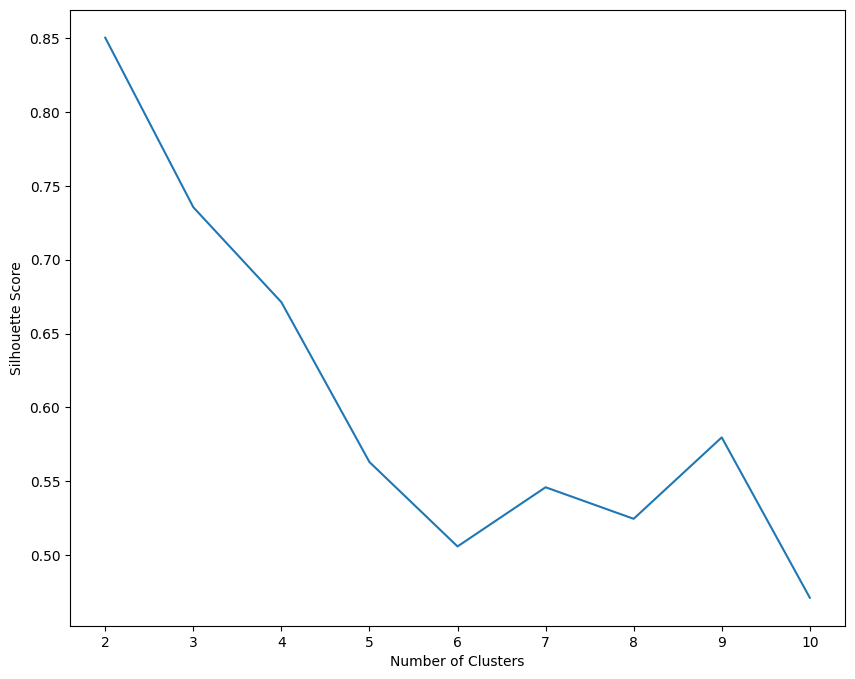

In [9]:
# Visualize sihouette score with the number of clusters
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(10,8))
ax.plot(range(2,11),silhouette_scores)
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Silhouette Score');

In [10]:
#Build the K-Means Clustering model
KMeans_=KMeans(featuresCol='iris_features', k=3) 
KMeans_Model=KMeans_.fit(assembled_data)
KMeans_Assignments=KMeans_Model.transform(assembled_data)

In [11]:
#Using PCA to visualize clustering
from pyspark.ml.feature import PCA as PCAml
pca = PCAml(k=2, inputCol="iris_features", outputCol="pca")
pca_model = pca.fit(assembled_data)
pca_transformed = pca_model.transform(assembled_data)

In [12]:
# Extract the principal components
import numpy as np
x_pca = np.array(pca_transformed.rdd.map(lambda row: row.pca).collect())

In [13]:
# Retrieve the cluster assignments from k-means assignments
cluster_assignment = np.array(KMeans_Assignments.rdd.map(lambda row: row.prediction).collect()).reshape(-1,1)

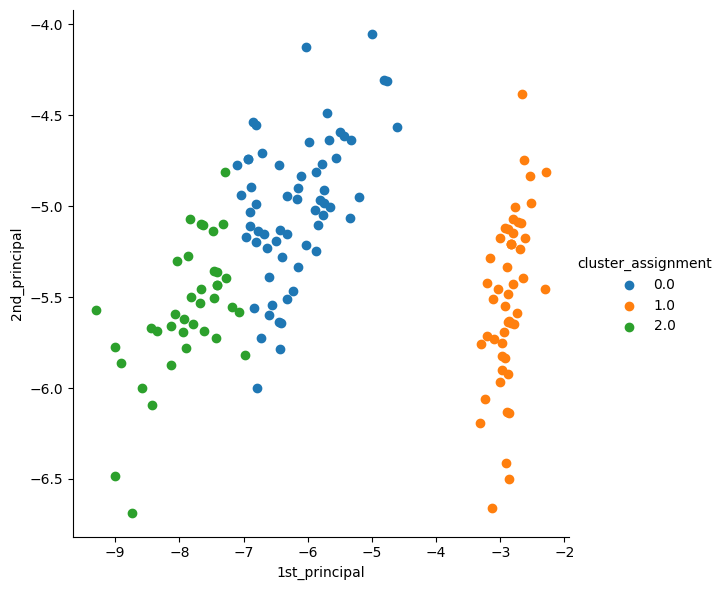

In [14]:
# Show clusters
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
pca_data = np.hstack((x_pca,cluster_assignment))

pca_df = pd.DataFrame(data=pca_data, columns=("1st_principal", "2nd_principal","cluster_assignment"))
sns.FacetGrid(pca_df,hue="cluster_assignment", height=6).map(plt.scatter, '1st_principal', '2nd_principal' ).add_legend()

plt.show()